In [7]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')

In [8]:
df0 = pd.read_csv('owid-energy-data.csv')

selected_cols = [
    "country", "year", "iso_code",
    "population", "electricity_demand",
    "greenhouse_gas_emissions",
    "fossil_share_elec", "renewables_share_elec"
]

energydata = df0[selected_cols]
energydata = energydata[energydata['year'] == 2021]
energydata = energydata.dropna()

energydata = energydata.rename(columns={
    'country': 'Country',
    'year': 'Year',
    'iso_code': 'ISO',
    'population': 'Population',
    'electricity_demand': 'Electricity demand',
    'greenhouse_gas_emissions': 'GHG emissions',
    'fossil_share_elec': 'FF electricity share',
    'renewables_share_elec': 'RE electricity share'
})

# Load income classifications
data = pd.ExcelFile('income_classification.xlsx')
df1 = pd.read_excel(data, sheet_name='Country Analytical History')

FY23_col = 36
startrow = 11
income_2021 = df1.iloc[startrow:, [0, 1, FY23_col]].dropna()
income_2021.columns = ["ISO", "Country Name", "Income Group FY23"]

# Merge
energydata["ISO"]  = energydata["ISO"].astype(str)
income_2021["ISO"] = income_2021["ISO"].astype(str)

finaldata = energydata.merge(income_2021[["ISO", "Income Group FY23"]], on="ISO", how="left")
finaldata = finaldata.dropna()

finaldata.head()

,Country,Year,ISO,Population,Electricity demand,GHG emissions,FF electricity share,RE electricity share,Income Group FY23
1,Albania,2021,ALB,2849591.0,8.39,0.21,0.000,100.000,UM
2,Algeria,2021,DZA,44761051.0,84.45,54.23,99.054,0.946,LM
3,American Samoa,2021,ASM,49202.0,0.17,0.11,100.000,0.000,UM
4,Angola,2021,AGO,34532382.0,16.85,2.91,24.570,75.430,LM
5,Antigua and Barbuda,2021,ATG,92316.0,0.35,0.22,94.286,5.714,H


In [9]:
df = finaldata[['FF electricity share',
                'RE electricity share',
                'GHG emissions',
                'Income Group FY23']].dropna()

# Define income clusters
low_group  = ['L', 'LM']
high_group = ['UM', 'H']

df['income_cluster'] = df['Income Group FY23'].apply(
    lambda x: 'Low/LM' if x in low_group else 'UM/H'
)

df.head()

,FF electricity share,RE electricity share,GHG emissions,Income Group FY23,income_cluster
1,0.000,100.000,0.21,UM,UM/H
2,99.054,0.946,54.23,LM,Low/LM
3,100.000,0.000,0.11,UM,UM/H
4,24.570,75.430,2.91,LM,Low/LM
5,94.286,5.714,0.22,H,UM/H


# First hypothesis: Correlation difference by income level

H₀: There is no difference in the correlation between GHG emissions and fossil-fuel electricity share across income groups. 

H₁: The correlation between GHG emissions and fossil-fuel electricity share differs by income level, with low- and lower-middle-income countries expected to show a weaker relationship because total emissions are constrained by low energy access and economic activity.

In [12]:
df_low  = df[df['income_cluster'] == 'Low/LM']
df_high = df[df['income_cluster'] == 'UM/H']

# Log-transform GHG emissions
df_low  = df_low.copy()
df_high = df_high.copy()

df_low['GHG_log']  = np.log10(df_low['GHG emissions']  + 1)
df_high['GHG_log'] = np.log10(df_high['GHG emissions'] + 1)


# Pearson correlations
r_low,  p_low  = stats.pearsonr(df_low['GHG_log'],  df_low['FF electricity share'])
r_high, p_high = stats.pearsonr(df_high['GHG_log'], df_high['FF electricity share'])

print("Correlation (Low/LM): ", r_low,  "p =", p_low)
print("Correlation (UM/H): ", r_high, "p =", p_high)

Correlation (Low/LM):  0.2614853872141999 p = 0.01913406929359418
Correlation (UM/H):  0.07384642788100101 p = 0.42083190427577005


In [5]:
def fisher_r_to_z(r):
    return 0.5 * np.log((1 + r) / (1 - r))

z_low  = fisher_r_to_z(r_low)
z_high = fisher_r_to_z(r_high)

n_low  = len(df_low)
n_high = len(df_high)

SE = np.sqrt( 1/(n_low - 3) + 1/(n_high - 3) )
Z  = (z_low - z_high) / SE
p_val = 2 * (1 - stats.norm.cdf(abs(Z)))

print("Fisher Z statistic:", Z)
print("p-value:", p_val)

Fisher Z statistic: 0.7588200489681369
p-value: 0.44796021066086267


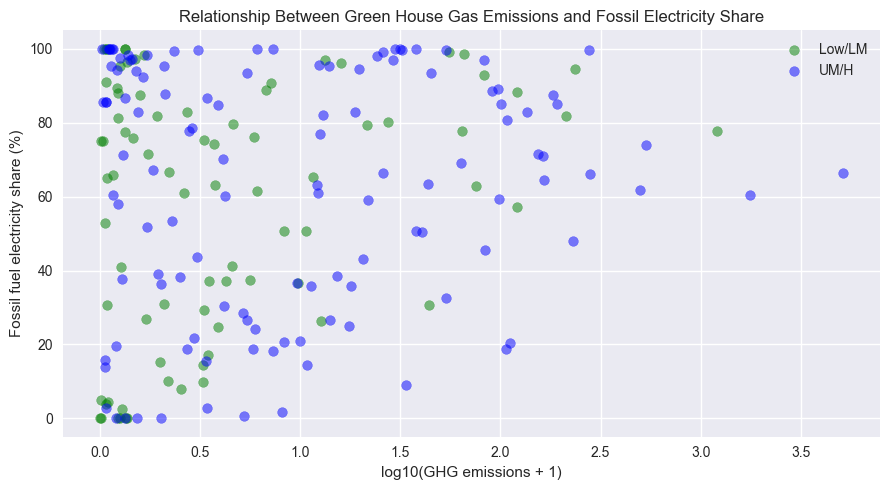

In [14]:
plt.figure(figsize=(9,5))

plt.scatter(df_low['GHG_log'], df_low['FF electricity share'],
            alpha=0.5, color='green', label='Low/LM')

plt.scatter(df_high['GHG_log'], df_high['FF electricity share'],
            alpha=0.5, color='blue', label='UM/H')

plt.xlabel("log10(GHG emissions + 1)")
plt.ylabel("Fossil fuel electricity share (%)")
plt.title("Relationship Between Green House Gas Emissions and Fossil Electricity Share")
plt.legend()
plt.tight_layout()
plt.show()

# Second hypothesis: Renewable electricity share across income groups 

H₀: There is no difference in renewable electricity share between income groups. 

H₁: Renewable electricity share differs between income groups.

In [16]:
model = ols('Q("RE electricity share") ~ C(Q("Income Group FY23"))', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
"C(Q(""Income Group FY23""))",6235.002187,3.0,2.051825,0.107943
Residual,199545.233240,197.0,NaN,NaN


In [17]:
tukey = pairwise_tukeyhsd(
    endog=df['RE electricity share'],
    groups=df['Income Group FY23'],
    alpha=0.05
)

print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     H      L   17.293 0.0798  -1.3524 35.9385  False
     H     LM   6.8627 0.6352  -8.1071 21.8324  False
     H     UM   3.0061 0.9563 -12.2187 18.2308  False
     L     LM -10.4304 0.5096 -29.9286  9.0679  False
     L     UM  -14.287 0.2401 -33.9817  5.4077  False
    LM     UM  -3.8566 0.9273 -20.1146 12.4014  False
-----------------------------------------------------


<Figure size 800x600 with 0 Axes>

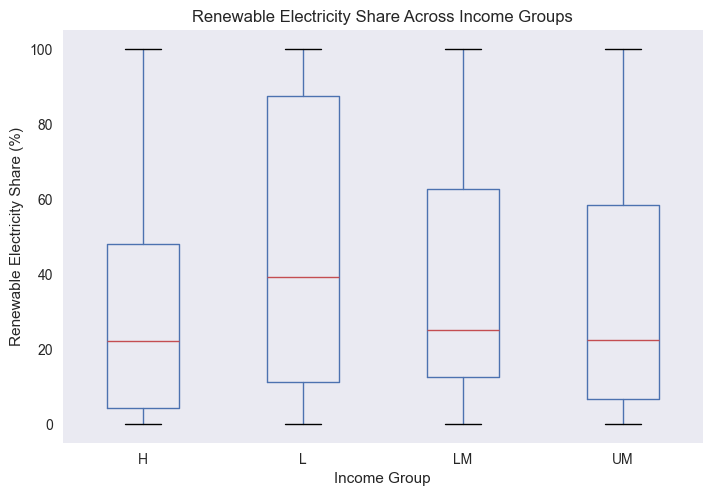

In [19]:
plt.figure(figsize=(8,6))
df.boxplot(column='RE electricity share',
           by='Income Group FY23',
           grid=False)

plt.title("Renewable Electricity Share Across Income Groups")
plt.suptitle("")  
plt.xlabel("Income Group")
plt.ylabel("Renewable Electricity Share (%)")
plt.show()